In [1]:
!pip install clean-text

     |████████████████████████████████| 64 kB 514 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=50124ba8d6ac780114f304a8c4f380d9852f4abc52d9bdd438cffb094f388f61
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from cleantext import clean

from tqdm.auto import tqdm
tqdm.pandas()

pd.options.display.max_colwidth = None

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Preparation

In [4]:
with open('../input/bhagwat-gita-in-english/gita.txt') as f:
    data = f.read()
df = pd.DataFrame({'text': data.split('\n')})
print(len(df))
df.head()  

2991


,text
0,I
1,Dhritirashtra:
2,Ranged thus for battle on the sacred plain--
3,"On Kurukshetra--say, Sanjaya! say"
4,"What wrought my people, and the Pandavas?"


In [5]:
clean_text = lambda x: clean(x,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=True,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=True,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="",
    replace_with_email="",
    replace_with_phone_number="",
    replace_with_number="",
    replace_with_digit="",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

In [6]:
df['cleaned'] = df['text'].progress_apply(clean_text)
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(r"\s\W*\s", "", x))
df['len'] = df['cleaned'].apply(lambda x: len(x.split()))

  0%|          | 0/2991 [00:00<?, ?it/s]

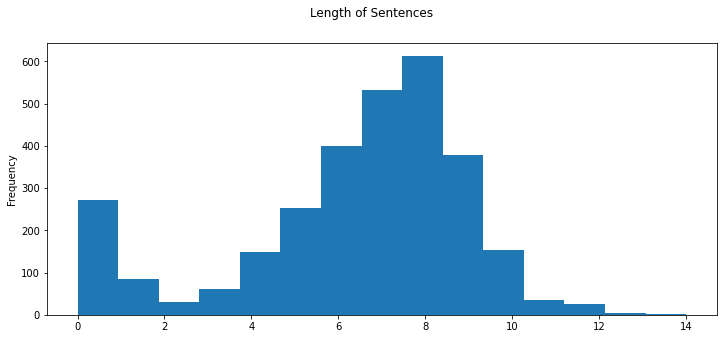

In [7]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Length of Sentences', fontsize=12)
df['len'].plot.hist(bins=15);

In [8]:
df = df[df['len'] > 1].drop_duplicates(subset=['cleaned']).reset_index(drop=True)

In [9]:
y = df.cleaned.values.tolist()

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@^_`{|}~\t\n')
tokenizer.fit_on_texts(y)
mask_token_id = len(tokenizer.word_index)+1
tokenizer.word_index.update({'[mask]': mask_token_id})

In [10]:
def get_masked_input(sequence):
    mask = np.random.randint(low=0, high=len(sequence))
    return [token if i != mask else mask_token_id for i, token in enumerate(sequence)]

In [11]:
VOCAB = len(tokenizer.word_index)
MAX_SEQ_LEN = 15
EMBEDDING_VECTOR_LENGTH = 32
N_LSTM_CELLS = 265
RECURRENT_DROPOUT = 0.5

In [12]:
y = tokenizer.texts_to_sequences(y)
x = [get_masked_input(seq) for seq in y]
x = pad_sequences(x, maxlen=MAX_SEQ_LEN, padding='post')
y = pad_sequences(y, maxlen=MAX_SEQ_LEN, padding='post')
y = keras.utils.to_categorical(y)

x.shape, y.shape

((2632, 15), (2632, 15, 3460))

# Model

2021-12-24 16:59:00.823359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 16:59:00.909817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 16:59:00.910574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-24 16:59:00.911722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 32)            110720    
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 530)           631760    
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 3460)          1837260   
Total params: 2,579,740
Trainable params: 2,579,740
Non-trainable params: 0
_________________________________________________________________


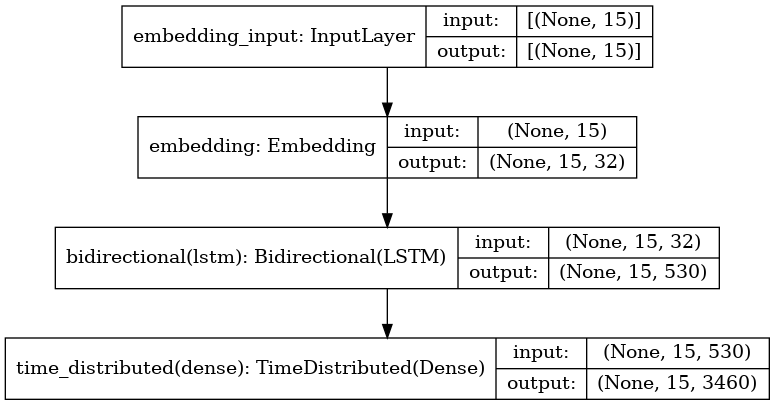

In [13]:
model = keras.models.Sequential([
    L.Embedding(input_dim=VOCAB, output_dim=EMBEDDING_VECTOR_LENGTH, input_length=MAX_SEQ_LEN),
    L.Bidirectional(L.LSTM(N_LSTM_CELLS, return_sequences=True, recurrent_dropout=RECURRENT_DROPOUT)),
    L.TimeDistributed(L.Dense(VOCAB, activation='softmax'))
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Training

In [14]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=x, y=y, validation_split=0.1, callbacks=[es, rlp], epochs=100)

2021-12-24 16:59:04.846898: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
74/74 [==============================] - 8s 62ms/step - loss: 4.4576 - acc: 0.5066 - val_loss: 3.4712 - val_acc: 0.5167
Epoch 2/100
74/74 [==============================] - 4s 52ms/step - loss: 3.3759 - acc: 0.5240 - val_loss: 3.3948 - val_acc: 0.5275
Epoch 3/100
74/74 [==============================] - 4s 52ms/step - loss: 3.2502 - acc: 0.5315 - val_loss: 3.3216 - val_acc: 0.5303
Epoch 4/100
74/74 [==============================] - 4s 56ms/step - loss: 3.1382 - acc: 0.5349 - val_loss: 3.2153 - val_acc: 0.5308
Epoch 5/100
74/74 [==============================] - 4s 53ms/step - loss: 3.0278 - acc: 0.5398 - val_loss: 3.1336 - val_acc: 0.5356
Epoch 6/100
74/74 [==============================] - 4s 57ms/step - loss: 2.9359 - acc: 0.5439 - val_loss: 3.0693 - val_acc: 0.5556
Epoch 7/100
74/74 [==============================] - 4s 56ms/step - loss: 2.8472 - acc: 0.5568 - val_loss: 3.0112 - val_acc: 0.5682
Epoch 8/100
74/74 [==============================] - 4s 53ms/step - loss: 2.

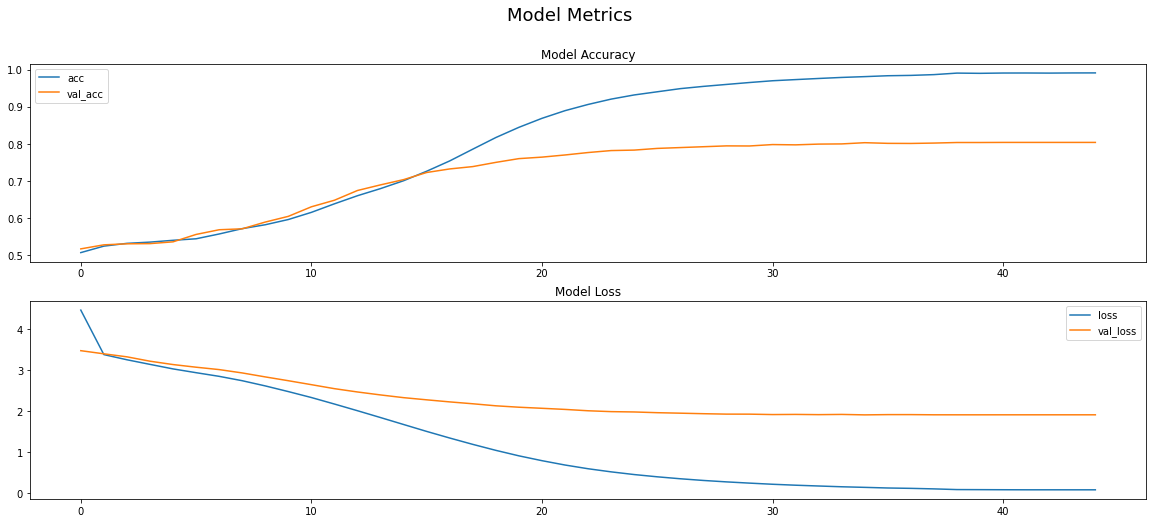

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
metrics = pd.DataFrame(history.history)
metrics[['acc', 'val_acc']].plot(ax=ax[0])
metrics[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

# Inference

In [16]:
query = "to die performing [mask] is no ill;"
query_token_ids = tokenizer.texts_to_sequences([query])
query_token_ids = pad_sequences(query_token_ids, maxlen=MAX_SEQ_LEN, padding='post')

pred = model(query_token_ids)
pred_seq = np.ravel(pred.numpy().argmax(axis=-1))
pred_text = ' '.join(tokenizer.index_word[token] for token in pred_seq if token != 0)
pred_text

'to die performing worshipping is no ill'